It's that time of the year in NYC: When the angle of the sunlight suggests that it should be autumn, but the foul, oozing, trash juice on your street curb enshrouding your entire block in oppressive swamp gas says otherwise. It's late September, and it's still effing hot in NYC. 

Every year around this time I get frustrated with the weather because I'm ready for pants, boots, and hot beverages, but summer always seems to hold on for a bit too long (this week, during the autumnal equinox, it reached >90º F). Each year this gets me thinking: Am I being impatient? Am I misremembering the past? Or have the last few years really been excessively warm in the early fall? Am I already perceiving climate change / global warming? This year, motivated by the [Climate Strike](https://www.nytimes.com/2019/09/20/nyregion/climate-strike-nyc.html), I decided to do more than bemoan the lingering summer, so I signed up for a developer account with [Dark Sky](https://darksky.net/dev) and started downloading historical weather data. This blog post is a naïve astronomer's attempt to make sense of local weather data: You have been warned.

First, a bunch of Python imports we'll need later...

In [1]:
import os
import datetime
import time

import astropy.table as at
import astropy.units as u
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import numpy as np

%matplotlib inline
import requests
from scipy.ndimage import gaussian_filter1d

import pandas as pd
from pandas.plotting import register_matplotlib_converters

register_matplotlib_converters()

I've already downloaded and cached daily weather data for NYC going back to 1968-01-01, available at the url in the cell below, so feel free to download that and skip down to "High temperatures around the fall equinox." But if you're interested in how I downloaded the data, keep reading.

In [2]:
cache_file = (
    "https://gist.githubusercontent.com/adrn/6455c48cb556d2f6f939c1e55b2308f8/raw/"
    "dedf6fd1989ab46baeab51058c788cca8aba4ca3/weather_cache_sm.csv"
)

## Download and cache daily weather data

Below, I've written a function that takes a longitude and latitude, a date range, and a secret key for the [Dark Sky weather API](https://darksky.net/dev) and returns a table of daily weather data.

In [3]:
@u.quantity_input(lon=u.degree, lat=u.degree)
def download_daily_weather(lon, lat, start_date, end_date, secret_key, cache=None):
    """Download daily weather data for the input Earth coordinates between the
    input dates.

    Parameters
    ----------
    lon : quantity_like
        Longitude.
    lat : quantity_like
        Latitude.
    start_date : `datetime.datetime`
        Start date to begin retrieving weather data.
    end_date : `datetime.datetime`
        Final date to retrieve weather data for.
    secret_key : str
        A Dark Sky weather API secret key for querying the API.
    cache : str, astropy.table.Table, pandas.DataFrame, optional
        If a string, this is assumed to be a filename. Otherwise,
        the input is converted to an astropy Table for use internally.

    Returns
    -------
    data : astropy.table.Table
        The daily weather data as an astropy Table object.

    """
    url_f = "https://api.darksky.net/forecast/{secret_key}/{lat:.4f},{lon:.4f}"
    url_f = url_f.format(
        lon=lon.to_value(u.degree), lat=lat.to_value(u.degree), secret_key=secret_key
    )
    url_f += ",{unix_time:.0f}?exclude=currently,flags,hourly"

    tbl = None
    save = False
    if cache is not None:
        if isinstance(cache, str):
            save = True
            # Only read it if it exists, otherwise we'll just save here later
            if os.path.exists(cache):
                tbl = at.Table.read(cache)
        elif isinstance(cache, at.Table):
            tbl = cache
        elif isinstance(cache, pd.DataFrame):
            tbl = at.Table.from_pandas(cache)
        else:
            raise ValueError(
                "cache must be a filename, astropy Table, or pandas DataFrame."
            )

    # Loop over all dates between the start and end dates
    delta = end_date - start_date
    for i in range(delta.days + 1):
        date = start_date + datetime.timedelta(days=i)

        mask = (
            np.isin(tbl["year"], date.year)
            & np.isin(tbl["month"], date.month)
            & np.isin(tbl["day"], date.day)
        )
        if mask.any():  # already have this date
            continue

        url = url_f.format(unix_time=time.mktime(date.timetuple()))
        resp = requests.get(url)
        if not resp.ok:
            print(
                "Failed to retrieve data for {}\n response returned: {}".format(
                    date, resp
                )
            )
            continue

        resp_data = resp.json()
        this_data = resp_data["daily"]["data"][0]
        this_data["year"] = date.year
        this_data["month"] = date.month
        this_data["day"] = date.day

        if tbl is None:
            tbl = at.Table([this_data])
        else:
            row_data = {k: this_data[k] for k in this_data.keys() if k in tbl.colnames}
            tbl.add_row(row_data)

    if save:
        tbl.write(cache, overwrite=True)

    return tbl

We'll pass in the longitude and latitude of NYC, and specify that we want to cache the data to a CSV file locally (which I downloaded already from the gist above, but you may want to re-run with your own city or date range):

In [4]:
nyc_lonlat = [-74.0060, 40.7128] * u.deg
cache_file = "weather_cache_sm.csv"

In [5]:
secret_key = os.environ.get("DARKSKY_KEY", None)

We'll download daily weather data from the beginning of 1968 through today (as I write):

In [6]:
start = datetime.datetime(1959, 1, 1)
today = datetime.datetime(2019, 9, 28)

data = download_daily_weather(
    nyc_lonlat[0], nyc_lonlat[1], start, today, secret_key=secret_key, cache=cache_file
)

The data table returned by my function is an astropy `Table`, but later it will be useful to have this also as a pandas `DataFrame`. Here I convert the table to a `DataFrame` and then set the index to the unique day of each row:

In [7]:
df = data.to_pandas()
df["date"] = pd.to_datetime(dict(year=df.year, month=df.month, day=df.day))
df = df.set_index("date")
df = df.sort_index()

## High temperatures around the fall equinox

As a first exploration of the data we have, we'll start by looking at historical high temperatures in the 7 days leading up to today. We'll first just plot the high temperatures as a function of year:

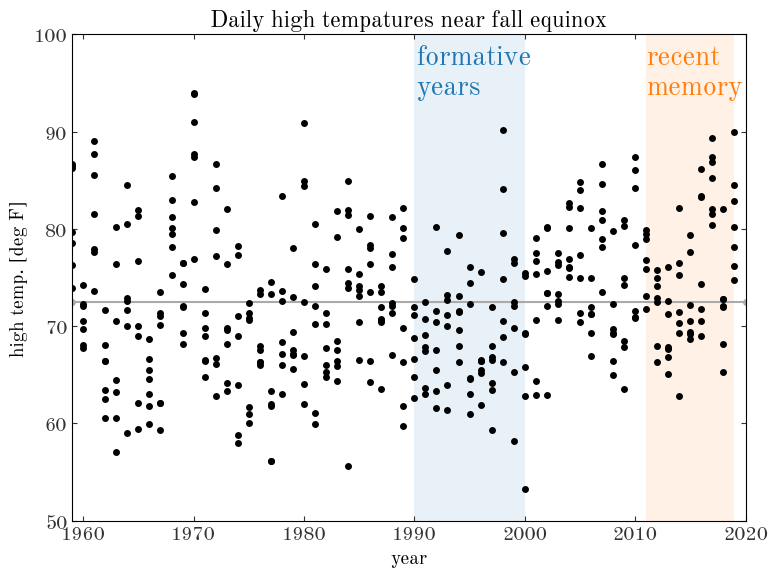

In [8]:
g = df[(df.month == 9) & (df.day > (today.day - 7)) & (df.day <= today.day)]

# Plot:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))

ax.plot(g["year"], g["temperatureHigh"], marker="o", ls="none", color="k")

ax.axvspan(1990, 2000, alpha=0.1, zorder=-100, color="tab:blue", lw=0)
ax.text(
    1990 + 0.2,
    99,
    "formative\nyears",
    fontsize=20,
    va="top",
    zorder=100,
    color="tab:blue",
)

ax.axvspan(2011, 2019, alpha=0.1, zorder=-100, color="tab:orange", lw=0)
ax.text(
    2011 + 0.1,
    99,
    "recent\nmemory",
    fontsize=20,
    va="top",
    zorder=100,
    color="tab:orange",
)

ax.set_xlim(1959, 2020)
ax.set_ylim(50, 100)

ax.set_xlabel("year")
ax.set_ylabel("high temp. [deg F]")

ax.set_title("Daily high tempatures near fall equinox")

ax.axhline(g["temperatureHigh"].mean(), zorder=-100, color="#aaaaaa")

fig.tight_layout()

In the above plot, black points are the high temperature values for 7 days near the fall equinox for years in my chosen date range. I've highlighted my "formative years," when I would have had noticed the weather as a kid, and I've also highlighted the last few years as "recent memory." The horizontal line shows the mean high temperature over the whole date range. The fall equinox itself stands out as the balmy 90 degree day on the far right of the plot.

From squinting at this plot, it does seem that high temperatures were more or less scattered around the mean during my youth, possibly even biased a bit "cool," whereas the last few years seem to have been quite warm. The mean seems to have shifted to hotter temperatures. The lower envelope of the high temperatures also seems to be warmer in recent years. So I'm going to interpret this as justifying my impatience with the late arrival of fall weather: It has been much warmer lately in early fall as compared to my childhood years!

Now that we have this data cached, we can obviously look at a lot of other things. Just for some other fun, I'll make a few more visualizations of the data below.

## Yearly temperature trends:

Another thing we can look at is how this year so far compares to historical weather data in terms of high and low temperatures. For example, we can compute daily temperature range percentiles and then see how this year compares to different percentile ranges over the course of the year:

In [9]:
# All weather data for this year so far:
this_year = df[df["year"] == 2019]

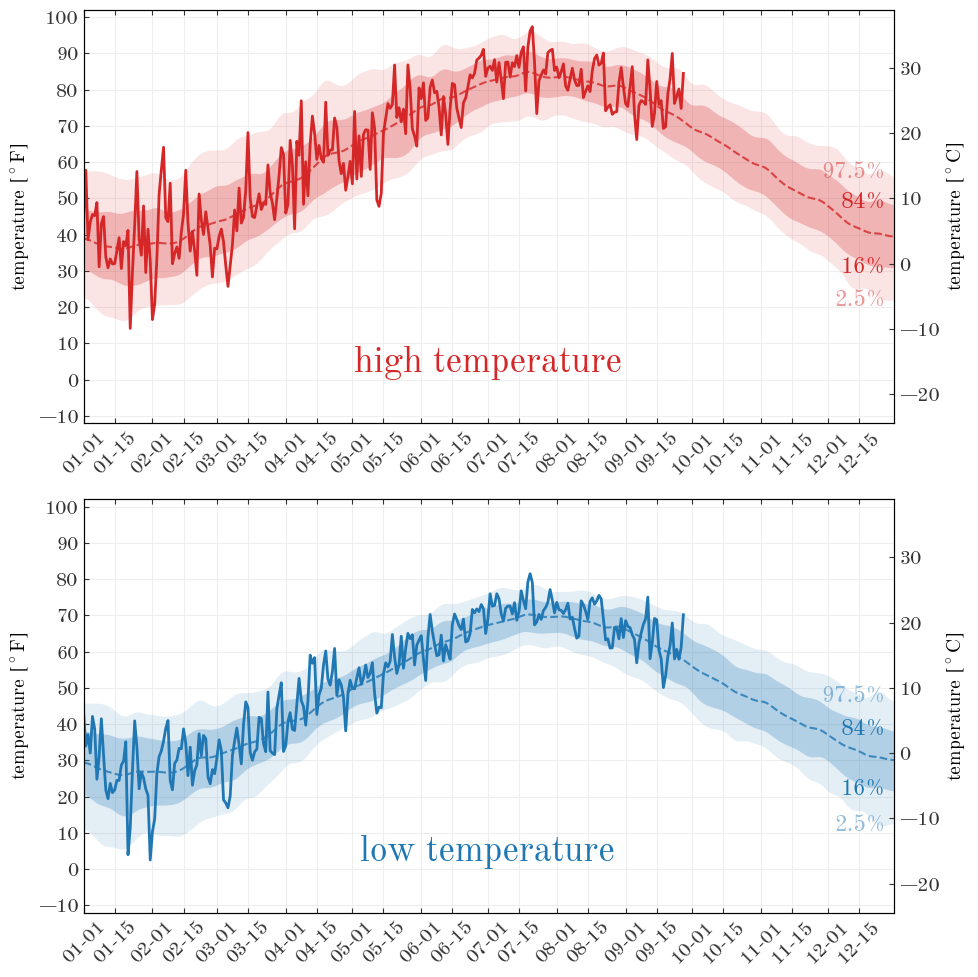

In [10]:
# Some parameters we might want to try playing with
smooth = 3.0  # days
plot_year = 2024  # we need to set an arbitrary year for plotting

# Percentile ranges to plot
qs = [[16, 84], [2.5, 97.5]]
q_alphas = [0.25, 0.12]

g = df.groupby(["month", "day"])

x = np.array(
    [datetime.datetime(plot_year, m, d) for m, d in g.groups.keys()],
    dtype=np.datetime64,
)

# ---

fig, axes = plt.subplots(2, 1, figsize=(10, 10), sharey=True)

# Repeat plots for high and low temperatures:
for ax, name, color in zip(axes, ["High", "Low"], ["tab:red", "tab:blue"]):
    colname = "temperature{0}".format(name)

    # Plot smoothed mean temp. trend:
    ax.plot(
        x,
        gaussian_filter1d(g.mean()[colname], smooth),
        color=color,
        marker="",
        alpha=0.8,
        linestyle="--",
        zorder=100,
    )

    # Plot bands for percentile ranges:
    percentiles = dict()
    for i, (_, row) in enumerate(g):
        for q1, q2 in qs:
            if q1 not in percentiles:
                percentiles[q1] = []
                percentiles[q2] = []
            percentiles[q1].append(np.percentile(row[colname], q1))
            percentiles[q2].append(np.percentile(row[colname], q2))

    for (q1, q2), alpha in zip(qs, q_alphas):
        y1 = gaussian_filter1d(percentiles[q1], smooth)
        y2 = gaussian_filter1d(percentiles[q2], smooth)
        ax.fill_between(x, y1, y2, zorder=100, color=color, linewidth=0, alpha=alpha)

        ax.text(
            x[-5],
            y1[-5],
            "{}%".format(q1),
            ha="right",
            va="center",
            fontsize=16,
            color=color,
            alpha=4 * alpha,
        )
        ax.text(
            x[-5],
            y2[-5],
            "{}%".format(q2),
            ha="right",
            va="center",
            fontsize=16,
            color=color,
            alpha=4 * alpha,
        )

    # Plot this year as a solid line on top:
    ax.plot(
        x[: len(this_year)],
        this_year[colname],
        color=color,
        lw=2,
        linestyle="-",
        marker="",
        zorder=101,
    )

    # Set axis limits and ticks
    ax.set_xlim(
        datetime.datetime(plot_year, 1, 1), datetime.datetime(plot_year, 12, 31)
    )
    ax.set_ylim(-12, 102)
    ax.yaxis.set_ticks(np.arange(-10, 100 + 1, 10))
    ax.grid(zorder=-10, color="#eeeeee")

    # Add a celsius axis for my homies
    ax_c = ax.twinx()
    ax_c.set_ylim(
        (ax.get_ylim() * u.imperial.Fahrenheit).to(u.Celsius, u.temperature()).value
    )

    ax.set_ylabel(r"temperature [$^\circ {\rm F}$]")
    ax_c.set_ylabel(r"temperature [$^\circ {\rm C}$]")

    ax.set_axisbelow(False)

    xticks = [
        datetime.datetime(plot_year, x, y) for x in range(1, 12 + 1) for y in [1, 15]
    ]
    ax.xaxis.set_ticks(xticks)

    myFmt = DateFormatter("%m-%d")
    ax.xaxis.set_major_formatter(myFmt)
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=45)

    ax.text(
        datetime.datetime(plot_year, 7, 1),
        0,
        "{} temperature".format(name.lower()),
        fontsize=26,
        ha="center",
        va="bottom",
        color=color,
    )

fig.tight_layout()
fig.set_facecolor("w")

In the above, the bands roughly correspong to 1- and 2-$\sigma$ yearly temperature trends (if the daily historical distribution of temperatures were Gaussian). The solid line represents the temperature trajectory for this year.

I was surprised and interested by a few observations in the above plot:
* The low temperatures in winter months in NYC have a much larger variance than in summer months
* The variance in high and low temperatures (which are probably strongly correlated) is much larger in winter months than in summer months
* On average, or smoothed over anomalies, NYC is really not as cold in winter as my perception would believe.

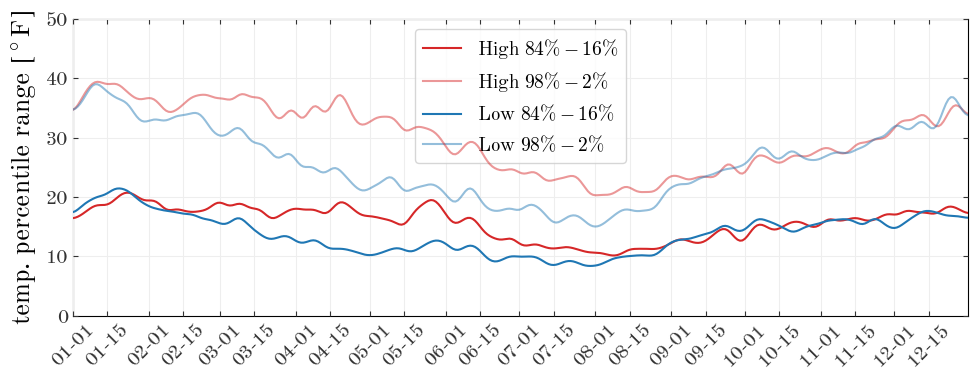

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(10, 4), sharey=True)

# Repeat plots for high and low temperatures:
for name, color in zip(["High", "Low"], ["tab:red", "tab:blue"]):
    colname = "temperature{0}".format(name)

    # Plot bands for percentile ranges:
    percentiles = dict()
    for i, (_, row) in enumerate(g):
        for q1, q2 in qs:
            if q1 not in percentiles:
                percentiles[q1] = []
                percentiles[q2] = []
            percentiles[q1].append(np.percentile(row[colname], q1))
            percentiles[q2].append(np.percentile(row[colname], q2))

    for (q1, q2), alpha in zip(qs, q_alphas):
        y1 = gaussian_filter1d(percentiles[q1], smooth)
        y2 = gaussian_filter1d(percentiles[q2], smooth)
        ax.plot(
            x,
            y2 - y1,
            color=color,
            marker="",
            zorder=100,
            alpha=4 * alpha,
            label="{2} ${0:.0f}\%-{1:.0f}\%$".format(q2, q1, name),
        )

    # Set axis limits and ticks
    ax.set_xlim(
        datetime.datetime(plot_year, 1, 1), datetime.datetime(plot_year, 12, 31)
    )
    ax.set_ylim(0, 50)
    ax.yaxis.set_ticks(np.arange(0, 50 + 1, 10))
    ax.grid(zorder=-100, color="#eeeeee")

    ax.set_ylabel(r"temp. percentile range [$^\circ {\rm F}$]", fontsize=19)
    ax.set_axisbelow(False)

    xticks = [
        datetime.datetime(plot_year, x, y) for x in range(1, 12 + 1) for y in [1, 15]
    ]
    ax.xaxis.set_ticks(xticks)

    myFmt = DateFormatter("%m-%d")
    ax.xaxis.set_major_formatter(myFmt)
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=45)

ax.legend(loc="best")
fig.tight_layout()
fig.set_facecolor("w")

The standard-deviation temperature range for high or low temperatures in winter is abot 20º F, and only about 10º F in summer.

The above plots are interesting, but collapse the whole historical records into percentiles or stationary statistics. The above would therefore obfuscate any, say, trends in temperatures (cough).

## Historical temperature trends by month

We can now look at how monthly mean temperatures have changed year-by-year. Let's bin the temperatured by month and plot the mean temperature in that month as a function of year. In each case, we'll try fitting a linear model to the data to see if there are any detectable long-term trends in the mean monthly high and low temperatures.

In [12]:
# For plotting month names:
month_names = dict()
month_names[1] = "Jan"
month_names[2] = "Feb"
month_names[3] = "Mar"
month_names[4] = "Apr"
month_names[5] = "May"
month_names[6] = "Jun"
month_names[7] = "Jul"
month_names[8] = "Aug"
month_names[9] = "Sep"
month_names[10] = "Oct"
month_names[11] = "Nov"
month_names[12] = "Dec"

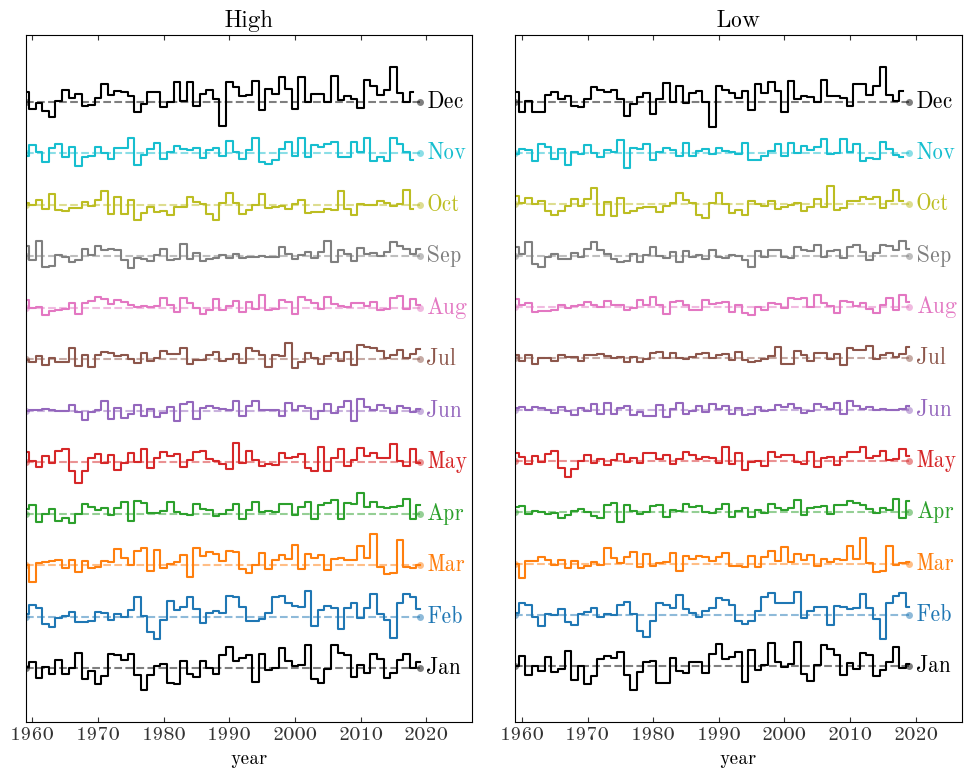

In [13]:
fig, axes = plt.subplots(1, 2, figsize=(10, 8), sharex=True)

slopes = dict()
slope_months = dict()
for ax, name in zip(axes, ["High", "Low"]):
    colname = "temperature{}".format(name)

    slopes[name] = []
    slope_months[name] = []
    for i in range(1, 12 + 1):
        sub = df[df["month"] == i]
        sub = sub.groupby("year").mean()

        years = sub[colname].index.values
        temps = sub[colname].values

        # Fit a linear model to high or low temp. vs. year and save slopes:
        coeff = np.polyfit(years, temps, deg=1)
        slopes[name].append(coeff[0] * 10)  # deg/year to dec/decade
        slope_months[name].append(i)

        zp = np.mean(temps[:10])
        (l,) = ax.plot(years, temps - zp + 20 * i, drawstyle="steps-mid", marker="")
        ax.plot(
            [1959, 2019],
            [20 * i, 20 * i],
            color=l.get_color(),
            zorder=-100,
            alpha=0.5,
            linestyle="--",
        )
        ax.text(
            2020,
            20 * i,
            month_names[i],
            color=l.get_color(),
            fontsize=16,
            ha="left",
            va="center",
        )

    ax.xaxis.set_ticks(np.arange(1960, 2020 + 1, 10))
    ax.set_title(name)
    ax.set_xlim(1959, 2027)
    ax.yaxis.set_visible(False)
    ax.set_xlabel("year")

fig.tight_layout()

In the above, the dashed line shows the mean of the first decade, projected across the full range of years. Visually, any signals are definitely subtle. However, especially in the winter months like December, there does seem to be a slight warming trend over time (the solid line appears above the extrapolated early mean). We can look at this quantitatively using the measured slopes of these temperature sequences: If there were no significant trends, I would expect the slopes to be distributed around 0 with some scatter.

Text(0.5, 0.04, 'slope $[{\\rm deg}~{\\rm decade}^{-1}]$')

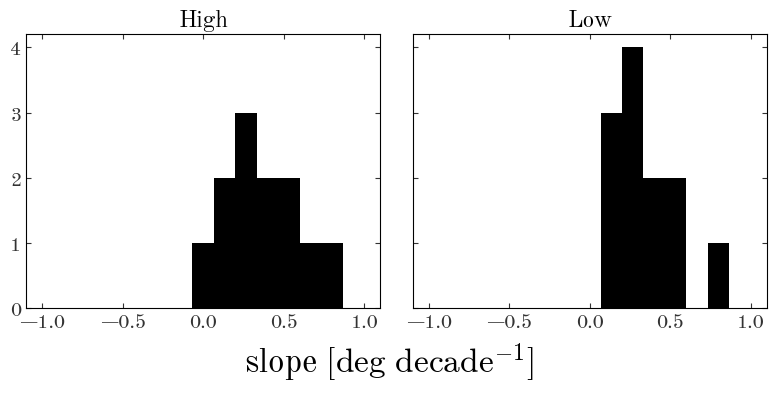

In [14]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)

for ax, name in zip(axes, ["High", "Low"]):
    colname = "temperature{}".format(name)

    ax.hist(slopes[name], bins=np.linspace(-1, 1, 16))
    ax.set_title(name)
    ax.xaxis.set_ticks(np.arange(-1, 1 + 1e-3, 0.5))

fig.tight_layout()
fig.subplots_adjust(bottom=0.2)
fig.text(0.5, 0.04, r"slope $[{\rm deg}~{\rm decade}^{-1}]$", ha="center", fontsize=24)

Instead, the slopes for each month are biased towards positive values for both high and low temperatures. We can also plot the slope as a function of month:

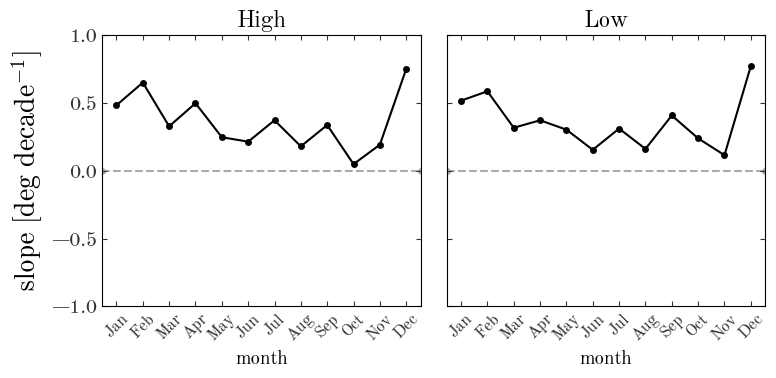

In [15]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)

for ax, name in zip(axes, ["High", "Low"]):
    colname = "temperature{}".format(name)
    ax.plot(slope_months[name], slopes[name], marker="o")
    ax.set_title(name)
    ax.set_xlabel("month")
    ax.xaxis.set_ticks(list(month_names.keys()))
    ax.xaxis.set_ticklabels(list(month_names.values()))
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, fontsize=12)
    ax.set_ylim(-1, 1)
    ax.axhline(0, zorder=-10, ls="--", color="#aaaaaa")

axes[0].set_ylabel(r"slope $[{\rm deg}~{\rm decade}^{-1}]$", fontsize=20)

fig.tight_layout()

It seems like winter months show a much larger warming signal, but all months show a positive long-term temperature trend.


## Conclusion

This is a very simplistic way of analyzing weather data, so I don't want to over-interpret these figures, but it does seem like there is a pretty obvious signature of climate change in these data: Especially in winter months, the mean high and low temperatures in NYC show a long-term warming trend from historical weather records, even dating back to just 1959. If you want to do something about this, use less energy, think about the products you purchase and industries you implicitly support, and join a [climate activism group](https://www.xrebellion.nyc).

---

## Bonus disappointing plot

I was hoping this would look more stunning, but here's a 2D visualization of temperature difference relative to the mean yearly remperature trend:

In [16]:
unq_years = sorted(np.unique(df["year"]))
low_temp_2d = np.full((365, len(unq_years)), np.nan)
high_temp_2d = np.full((365, len(unq_years)), np.nan)

for i, year in enumerate(unq_years):
    # I'm going to drop Feb 29 because I'm lazy!
    no_feb29_mask = np.logical_not((df["month"] == 2) & (df["day"] == 29))
    full_year = df[(df["year"] == year) & no_feb29_mask]
    low_temp_2d[: len(full_year), i] = full_year["temperatureLow"].values
    high_temp_2d[: len(full_year), i] = full_year["temperatureHigh"].values

xe = np.concatenate((unq_years, [2020]))  # years
ye = np.arange(0, 365 + 1)  # day of year

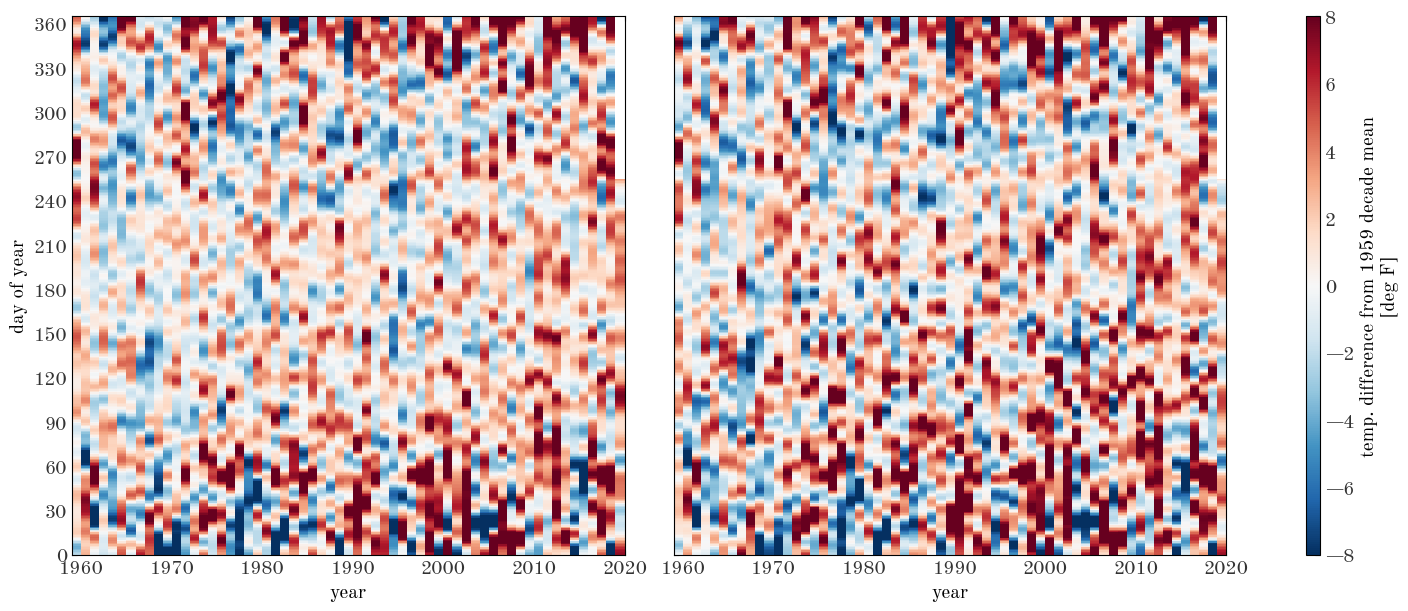

In [17]:
fig, axes = plt.subplots(
    1, 2, figsize=(14, 6), sharex=True, sharey=True, constrained_layout=True
)

ax = axes[0]
X = gaussian_filter1d(low_temp_2d, 4, axis=0)
im = ax.pcolormesh(
    xe, ye, X - np.mean(X[:, :10], axis=1)[:, None], vmin=-8, vmax=8, cmap="RdBu_r"
)

ax = axes[1]
X = gaussian_filter1d(high_temp_2d, 4, axis=0)
im = ax.pcolormesh(
    xe, ye, X - np.mean(X[:, :10], axis=1)[:, None], vmin=-8, vmax=8, cmap="RdBu_r"
)

for ax in axes:
    ax.invert_yaxis()
    ax.yaxis.tick_left()
    ax.yaxis.set_ticks(np.arange(0, 365, 30))
    ax.set_xlabel("year")

axes[0].set_ylabel("day of year")

cb = fig.colorbar(im, ax=axes, aspect=40)
cb.set_label("temp. difference from 1959 decade mean\n[deg F]")